# Vanilla Autoencoder

The notebook shows how simple autoencoders built from fully connected layers can be 
designed with Knet and Helferlein.    
The 64x64 example images are in the NNHelderlein data-directory.

In [1]:
using Knet
using NNHelferlein
using Images

### Data
Load images from directory, flatten the 64x64x3 tensors to a 1-D-vecor and
build a matrix with 12288 rows (= RGB-values of all pixels) and 
4 columns (= number of pictures).   

Training data must be flattened because each image is represented by a 1D-vector 
in the perceptron.    
Final training tensor is (num-pixels x 3) x (num images):

,,,,

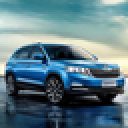
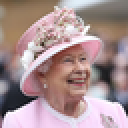
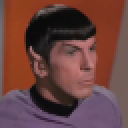
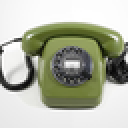
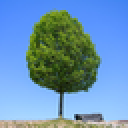

In [2]:
d = joinpath(NNHelferlein.DATA_DIR, "Images64")
imgs = [load(joinpath(d, i)) for i in readdir(d) if occursin("png", i)]

In [3]:
trn = hcat(vec.(image2array.(imgs))...)
trn = convert2KnetArray(trn)
size(trn)

(12288, 5)

Here is how to get the images back from the tensors:

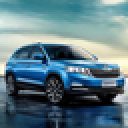

In [4]:
array2image(reshape(trn[:,1], 64,64,3))

## The Autoencoder:

Defining AutoEncoder as a subtype of `DNN` makes the overloaded `summary()` and `print_network()` functions working:

In [5]:
struct AutoEncoder <: AbstractNN
    layers
    AutoEncoder(e,d) = new([e,d])
end

function (ae::AutoEncoder)(x)
    
    # encode - decode:
    #
    x = ae.layers[1](x)
    x = ae.layers[2](x)
    return x
end

# square loss:
#
(ae::AutoEncoder)(x, y) = sum(abs2, ae(x) .- y)

#### Define encoder and decoder as MLPs and combine them to the AE:

In [6]:
actf = sigm
encoder = Chain(
    Dense(64*64*3, 512, actf=actf),
    Dense(512, 64, actf=actf),
    Dense(64, 8, actf=actf))

decoder = Chain(
    Dense(8, 64, actf=actf),
    Dense(64, 512, actf=actf),
    Dense(512, 64*64*3, actf=actf))

Chain(Any[Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(64,8)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(64)), Knet.Ops20.sigm), Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(512,64)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(512)), Knet.Ops20.sigm), Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(12288,512)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(12288)), Knet.Ops20.sigm)])

In [7]:
ae = AutoEncoder(encoder, decoder)

AutoEncoder(Chain[Chain(Any[Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(512,12288)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(512)), Knet.Ops20.sigm), Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(64,512)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(64)), Knet.Ops20.sigm), Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,64)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), Knet.Ops20.sigm)]), Chain(Any[Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(64,8)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(64)), Knet.Ops20.sigm), Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(512,64)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(512)), Knet.Ops20.sigm), Dense(P(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(12288,512)), P(CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(12288)), Knet.Ops20.sigm)])])

In [8]:
summary(ae)

NNHelferlein neural network of type AutoEncoder:
 
  Chain of type Chain:
    Dense layer 12288 → 512 with sigm,                         6291968 params
    Dense layer 512 → 64 with sigm,                              32832 params
    Dense layer 64 → 8 with sigm,                                  520 params
  Chain of type Chain:
    Dense layer 8 → 64 with sigm,                                  576 params
    Dense layer 64 → 512 with sigm,                              33280 params
    Dense layer 512 → 12288 with sigm,                         6303744 params
 
Total number of layers: 6
Total number of parameters: 12662920


6

We test the AE with one argument (i.e. predict) and with two (i.e. calculate loss):

In [10]:
@show size(ae(trn))
@show loss = ae(trn, trn);

size(ae(trn)) = (12288, 5)
loss = ae(trn, trn) = 5261.058f0


Create one minibatch with all 4 images (Knet default),
train with NNHelferlein's `tb_train()` for about 1 min on a nvidia GPU
and display the reconstructed images:

In [11]:
mbs = minibatch(trn, trn, 5)

1-element Knet.Train20.Data{Tuple{CuArray{Float32}, CuArray{Float32}}}

Training 5000 epochs with 1 minibatches/epoch.
Evaluation is performed every 1 minibatches with 1 mbs.
Watch the progress with TensorBoard at:
/home/andreas/Documents/Projekte/2022-NNHelferlein_KnetML/NNHelferlein/examples/logs/run/2022-12-21T16-16-51


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13m


Training finished with:
Training loss:       12.421581


,,,,

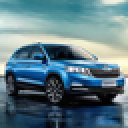
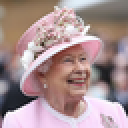
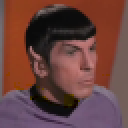
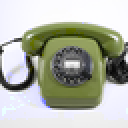
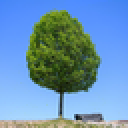

In [12]:
ae = tb_train!(ae, Adam, mbs, epochs=5000, lr=0.0002)
y = ae(trn)
[array2image(reshape(y[:,i], 64,64,3)) for i in 1:size(y)[end]]